## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
gsw = pd.read_excel('data/gsw_yields.xlsx', index_col=0, parse_dates=True)

maturities = [2,5,10]
yields = gsw[maturities].dropna()
yields.columns = ['2Y','5Y','10Y']

yields = yields.loc['2015':]

yields_diff = yields.diff(periods=1).dropna()
yields_diff.tail()


scaler = StandardScaler()
yields_diff_scaled = scaler.fit_transform(yields_diff)

## Question 2: Butterfly Construction

**Construct a 2s5s10s butterfly that is neutral to PC1 and PC2.**

### a) Rescale the PC3 loadings so $w_{5Y} = -1$ (short the belly) and PC1 exposure = 0 = PC2 exposure.

In [3]:
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=3)
pca.fit(yields_diff_scaled)
explained_variance = pca.explained_variance_ratio_
components = pca.components_
for i, (var, comp) in enumerate(zip(explained_variance, components), start=1):
    print(f"Principal Component {i}:")
    print(f"  Explained Variance: {var:.4f}")
    print(f"  Loadings: {comp}")

Principal Component 1:
  Explained Variance: 0.9106
  Loadings: [0.5637756  0.60007277 0.5675119 ]
Principal Component 2:
  Explained Variance: 0.0810
  Loadings: [ 0.72511252 -0.03063236 -0.68794875]
Principal Component 3:
  Explained Variance: 0.0084
  Loadings: [-0.39543508  0.7993587  -0.45239005]


In [4]:
weights = np.array(-components[2] / components[2][1])
print("Weights for the expected weights:", weights)

%store weights

Weights for the expected weights: [ 0.49469041 -1.          0.56594124]
Stored 'weights' (ndarray)


### b) Verify your construction: Compute the butterfly portfolio's exposure to PC1, PC2, and PC3. Confirm that PC1 and PC2 exposures are approximately zero.

In [5]:
PC1_exposure = np.dot(components[0], weights)
print("Exposure to PC1:", PC1_exposure)
PC2_exposure = np.dot(components[1], weights)
print("Exposure to PC2:", PC2_exposure)

Exposure to PC1: 0.0
Exposure to PC2: -2.42861286636753e-17


#### - PC1 and PC2 exposures are approximately zero

### c) Compute the butterfly spread time series:
   $$\text{Spread}_t = w_{2Y} \times y_{2Y,t} + w_{5Y} \times y_{5Y,t} + w_{10Y} \times y_{10Y,t}$$

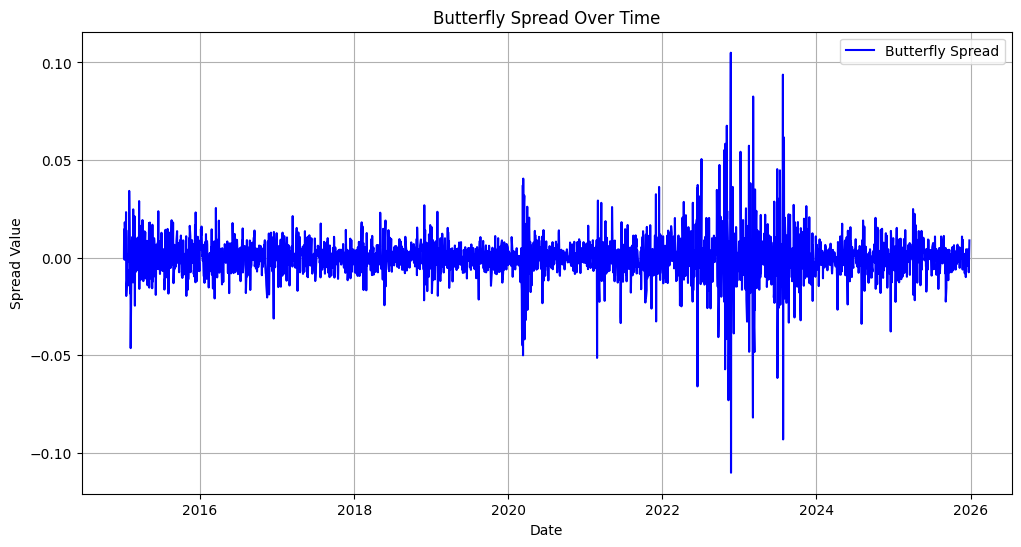

In [6]:
spread_result = []

for i in range(len(yields_diff)):
    yield_array = yields_diff.iloc[i].values
    spread = np.dot(weights, yield_array)
    spread_result.append(spread)

spread_result = np.array(spread_result)
plt.figure(figsize=(12,6))
plt.plot(yields_diff.index, spread_result, label='Butterfly Spread', color='blue')
plt.title('Butterfly Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()
plt.grid()
plt.show()

### d) Report summary statistics (mean, standard deviation, min, max) for the spread and plot the series. Does the spread appear to exhibit mean-reversion?

In [7]:
statistis = {
    'Mean': np.mean(spread_result),
    'Std Dev': np.std(spread_result),
    'Min': np.min(spread_result),
    'Max': np.max(spread_result)}

print("Butterfly Spread Statistics:")
for stat, value in statistis.items():
    print(f"{stat}: {value:.4f}")   

Butterfly Spread Statistics:
Mean: 0.0002
Std Dev: 0.0110
Min: -0.1102
Max: 0.1050


Yes, the spread appears to exihibit mean-reversion.